<a href="https://colab.research.google.com/github/danishansari9422/Sentimental_Analysis/blob/main/Sentiment_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
%matplotlib inline

In [ ]:
from google.colab import files
import pandas as pd

uploaded = files.upload()
filename = next(iter(uploaded))

Saving Train.csv to Train.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB
None
(40000, 2)
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
5  A terrible movie as everyone has said. What ma...      0
6  Finally watched this shocking movie last night...      1
7  I caught this film on AZN on cable. It sounded...      0
8  It may be the remake of 1987 Autumn's Tale aft...      1
9  My Super Ex Girlfriend turned out to be a plea...      1


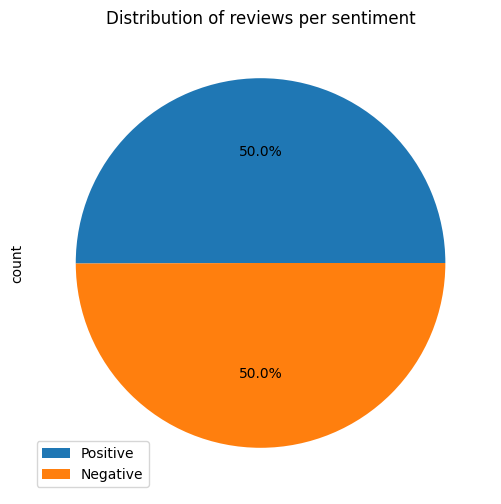

In [ ]:
imdb=pd.read_csv('/content/Train.csv')
print(imdb.info())
print(imdb.shape)
print(imdb.head(10))

imdb['label'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')

In [ ]:
from sklearn.model_selection import train_test_split

features = imdb.drop("label",axis=1)
labels = imdb["label"]

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.90, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.5, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state=42)

print("Data distribution:\n- Train: {} \n- Validation: {} \n- Test: {}".format(len(y_train),len(y_val),len(y_test)))

Data distribution:
- Train: 2000 
- Validation: 1000 
- Test: 1000


In [ ]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

In [ ]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

Processing data...
Creating word clouds...


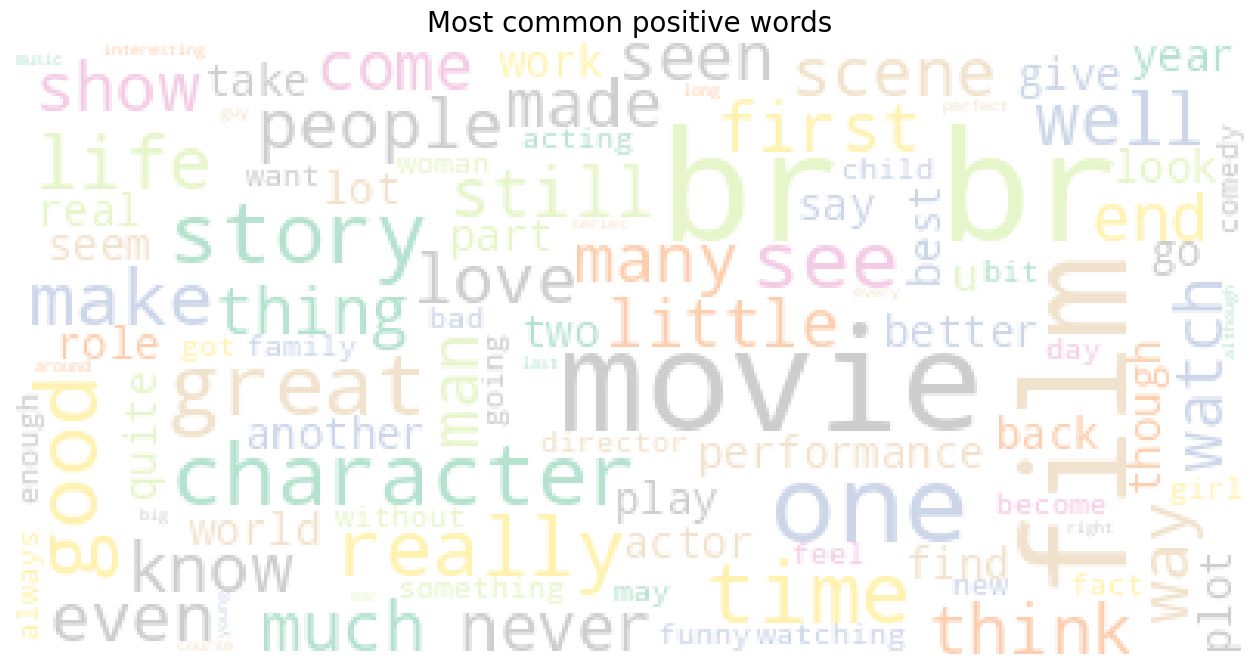

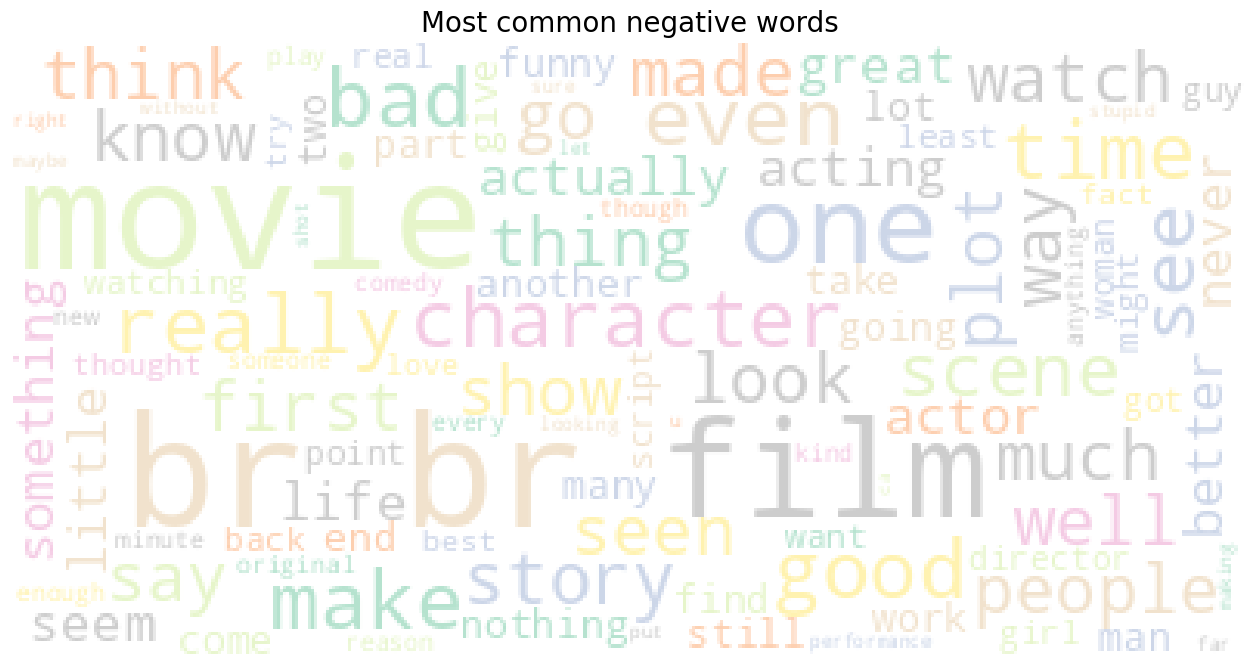

In [ ]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="white", max_words=100, max_font_size=50)
    wc.generate(words)
    plt.title("Most common {} words".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')

imdb=imdb.head(1000)
print("Processing data...")
imdb['clean']=imdb['text'].map(clean)
imdb['clean_text']=imdb['clean'].apply(lambda x: " ".join([str(word) for word in x]))

print("Creating word clouds...")
positive_words=" ".join(imdb[imdb.label==1]['clean_text'].values)
negative_words=" ".join(imdb[imdb.label==0]['clean_text'].values)

generate_wordcloud(positive_words,"positive")
generate_wordcloud(negative_words,"negative")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer=clean)
tfidf_vect_fit=tfidf_vect.fit(X_train['text'])
X_train=vectorize(X_train['text'],tfidf_vect_fit)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier()
scores = cross_val_score(rf,X_train,y_train.values.ravel(),cv=5)

In [ ]:
print(scores)
scores.mean()

[0.795  0.7875 0.7725 0.82   0.7875]


0.7925

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(X_train,y_train.values.ravel())
print_results(cv)

BEST PARAMS: {'max_depth': 20, 'n_estimators': 100}

0.573 (+/-0.069) for {'max_depth': 2, 'n_estimators': 5}
0.68 (+/-0.037) for {'max_depth': 2, 'n_estimators': 50}
0.737 (+/-0.042) for {'max_depth': 2, 'n_estimators': 100}
0.644 (+/-0.034) for {'max_depth': 10, 'n_estimators': 5}
0.753 (+/-0.02) for {'max_depth': 10, 'n_estimators': 50}
0.796 (+/-0.026) for {'max_depth': 10, 'n_estimators': 100}
0.662 (+/-0.037) for {'max_depth': 20, 'n_estimators': 5}
0.761 (+/-0.024) for {'max_depth': 20, 'n_estimators': 50}
0.799 (+/-0.045) for {'max_depth': 20, 'n_estimators': 100}
0.656 (+/-0.034) for {'max_depth': None, 'n_estimators': 5}
0.791 (+/-0.028) for {'max_depth': None, 'n_estimators': 50}
0.798 (+/-0.039) for {'max_depth': None, 'n_estimators': 100}


In [ ]:
cv.best_estimator_

RandomForestClassifier(max_depth=20)

In [ ]:
X_val=vectorize(X_val['text'],tfidf_vect_fit)

In [ ]:
rf1 = RandomForestClassifier(n_estimators=100,max_depth=20)
rf1.fit(X_train, y_train.values.ravel())
rf2 = RandomForestClassifier(n_estimators=100,max_depth=None)
rf2.fit(X_train, y_train.values.ravel())
rf3 = RandomForestClassifier(n_estimators=5,max_depth=None)
rf3.fit(X_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=5)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

for mdl in [rf1,rf2,rf3]:
    y_pred = mdl.predict(X_val)
    accuracy = round(accuracy_score(y_val,y_pred), 3)
    precision = round(precision_score(y_val,y_pred), 3)
    recall = round(recall_score(y_val,y_pred), 3)
    print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(mdl.max_depth, mdl.n_estimators,accuracy,precision, recall))

MAX DEPTH: 20 / # OF EST: 100 -- A: 0.83 / P: 0.816 / R: 0.843
MAX DEPTH: None / # OF EST: 100 -- A: 0.835 / P: 0.836 / R: 0.824
MAX DEPTH: None / # OF EST: 5 -- A: 0.698 / P: 0.684 / R: 0.712


In [ ]:
X_test=vectorize(X_test['text'],tfidf_vect_fit)

y_pred = rf2.predict(X_test)
accuracy = round(accuracy_score(y_test,y_pred), 3)
precision = round(precision_score(y_test,y_pred), 3)
recall = round(recall_score(y_test,y_pred), 3)
print('MAX DEPTH: {} / # OF EST: {} -- A: {} / P: {} / R: {}'.format(rf3.max_depth,
                                                                     rf3.n_estimators,
                                                                     accuracy,
                                                                     precision,
                                                                     recall))

MAX DEPTH: None / # OF EST: 5 -- A: 0.829 / P: 0.827 / R: 0.815


In [ ]:
def predict_sentiment(sentence, model, vectorizer):
    # Preprocess the sentence using the vectorizer
    sentence_tfidf = vectorizer.transform([sentence])

    # Predict the sentiment
    prediction = model.predict(sentence_tfidf)

    # Map the prediction to a sentiment label
    sentiment = "Positive" if prediction == 1 else "Negative"

    return sentiment

In [ ]:
new_sentence = "The movie was terrible"
sentiment = predict_sentiment(new_sentence, rf1, tfidf_vect)
print(f"Sentiment of the new sentence: {sentiment}")

Sentiment of the new sentence: Negative
